In [1]:
# Colab: basic system and library setup (A100 will be auto-used via GPU runtime)
!nvidia-smi

!pip install -q transformers datasets seqeval matplotlib seaborn pandas tqdm


Fri Nov 28 09:48:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             44W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
import os
import re
from collections import Counter

import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer

sns.set(style="whitegrid")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [3]:
from google.colab import files
uploaded = files.upload()
uploaded.keys()


Saving FindVehicle_test.txt to FindVehicle_test.txt
Saving FindVehicle_train.txt to FindVehicle_train.txt


dict_keys(['FindVehicle_test.txt', 'FindVehicle_train.txt'])

In [4]:
train_path = "FindVehicle_train.txt"
test_path  = "FindVehicle_test.txt"

def read_conll(path):
    sentences = []
    labels = []
    cur_tokens = []
    cur_labels = []

    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                if cur_tokens:
                    sentences.append(cur_tokens)
                    labels.append(cur_labels)
                    cur_tokens, cur_labels = [], []
                continue

            parts = line.split()
            if len(parts) == 1:
                token, tag = parts[0], "O"
            else:
                token, tag = parts[0], parts[1]

            cur_tokens.append(token)
            cur_labels.append(tag)

    if cur_tokens:
        sentences.append(cur_tokens)
        labels.append(cur_labels)

    return sentences, labels

train_sentences, train_labels_raw = read_conll(train_path)
test_sentences,  test_labels_raw  = read_conll(test_path)

print("Train sentences:", len(train_sentences))
print("Test sentences:", len(test_sentences))


Train sentences: 21565
Test sentences: 20777


In [5]:
# Build data frame for EDA:

def to_dataframe(sentences, labels, split_name):
    rows = []
    for sid, (tokens, tags) in enumerate(zip(sentences, labels)):
        for tid, (tok, tag) in enumerate(zip(tokens, tags)):
            rows.append({
                "split": split_name,
                "sentence_id": sid,
                "token_id": tid,
                "token": tok,
                "tag": tag
            })
    return pd.DataFrame(rows)

df_train = to_dataframe(train_sentences, train_labels_raw, "train")
df_test  = to_dataframe(test_sentences,  test_labels_raw,  "test")

df_train.head()


,split,sentence_id,token_id,token,tag
0,train,0,0,Find,O
1,train,0,1,the,O
2,train,0,2,van,B-vehicle_type
3,train,0,3,located,O
4,train,0,4,in,O


In [6]:
assert len(df_train) == sum(len(s) for s in train_sentences)
assert len(df_test)  == sum(len(s) for s in test_sentences)


# EDA: tag prefixes and rare tags

In [7]:
# Tag prefix distribution (O / B / I / E / OTHER)

def tag_prefix(tag):
    if tag == "O":
        return "O"
    if "-" not in tag:
        return "OTHER"
    pref, _ = tag.split("-", 1)
    return pref

df_train["tag_prefix"] = df_train["tag"].apply(tag_prefix)
print(df_train["tag_prefix"].value_counts())


tag_prefix
O        357549
B        100783
I         45955
E         45565
OTHER        26
Name: count, dtype: int64


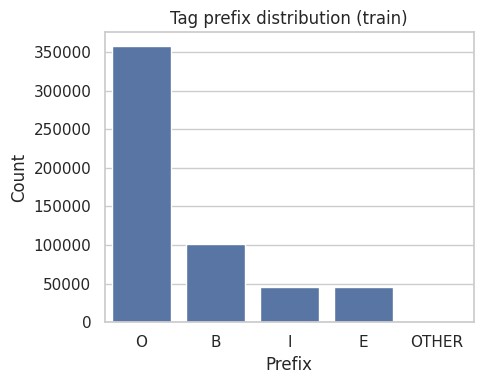

In [8]:
plt.figure(figsize=(5,4))
sns.countplot(
    x="tag_prefix",
    data=df_train,
    order=df_train["tag_prefix"].value_counts().index
)
plt.title("Tag prefix distribution (train)")
plt.xlabel("Prefix")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [9]:
# Full tag frequency and rare tags

tag_counts = df_train["tag"].value_counts().sort_values(ascending=False)
tag_counts.head(20)



,count
tag,
O,357549
B-vehicle_color,19461
B-vehicle_brand,18073
B-vehicle_model,18067
I-vehicle_model,11659
B-vehicle_location,11431
E-vehicle_model,11105
I-vehicle_velocity,11054
B-vehicle_velocity,8306


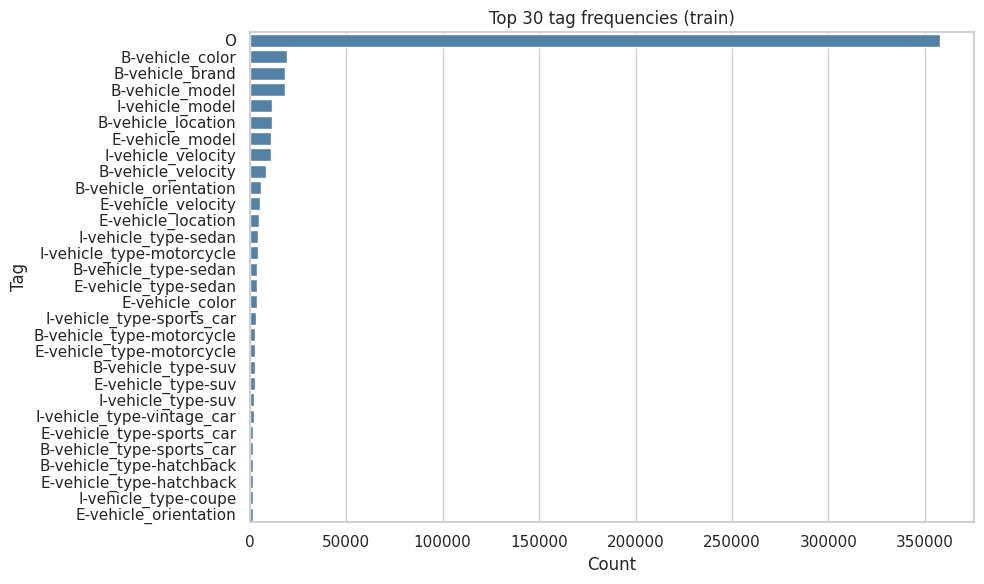

In [10]:
plt.figure(figsize=(10,6))
sns.barplot(x=tag_counts.values[:30], y=tag_counts.index[:30], color="steelblue")
plt.title("Top 30 tag frequencies (train)")
plt.xlabel("Count")
plt.ylabel("Tag")
plt.tight_layout()
plt.show()


In [11]:
rare_tags = tag_counts[tag_counts < 20]
rare_tags


,count
tag,
recharge,17
Sport,9


# EDA: sentence lengths and entity ratios



In [12]:
# Sentence length

train_lengths = df_train.groupby("sentence_id")["token_id"].max() + 1
test_lengths  = df_test.groupby("sentence_id")["token_id"].max() + 1

print("Train lengths summary:")
print(train_lengths.describe())


Train lengths summary:
count    21565.000000
mean        25.498632
std          9.522940
min         10.000000
25%         20.000000
50%         24.000000
75%         30.000000
max         53.000000
Name: token_id, dtype: float64


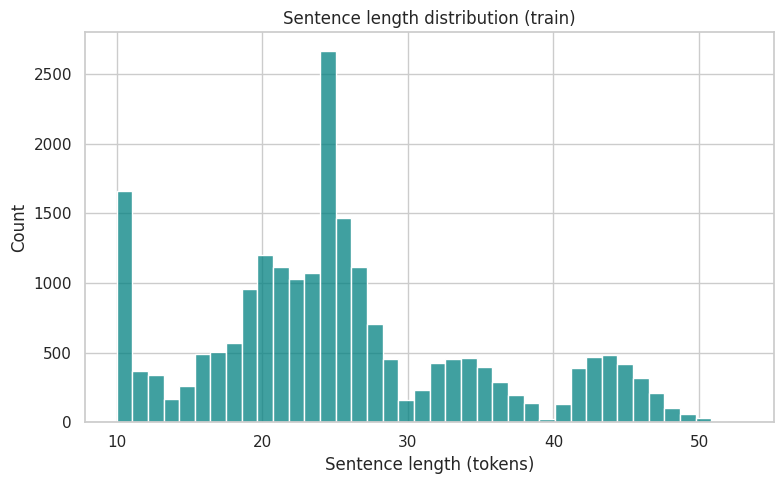

In [13]:
plt.figure(figsize=(8,5))
sns.histplot(train_lengths, bins=40, kde=False, color="teal")
plt.title("Sentence length distribution (train)")
plt.xlabel("Sentence length (tokens)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


Entity token ratio (train): 0.350


/tmp/ipython-input-382817414.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


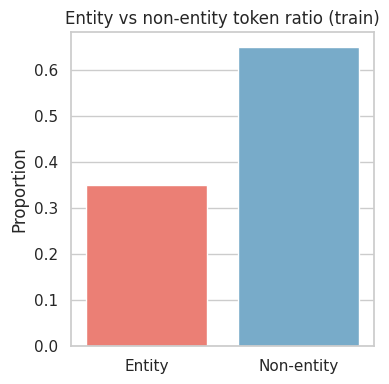

In [14]:
# Entity vs non-entity tokens

df_train["is_entity"] = df_train["tag"].apply(lambda t: t != "O")
entity_ratio = df_train["is_entity"].mean()
print(f"Entity token ratio (train): {entity_ratio:.3f}")

plt.figure(figsize=(4,4))
sns.barplot(
    x=["Entity", "Non-entity"],
    y=[entity_ratio, 1 - entity_ratio],
    palette=["#FF6F61", "#6BAED6"]
)
plt.title("Entity vs non-entity token ratio (train)")
plt.ylabel("Proportion")
plt.tight_layout()
plt.show()


In [15]:
# Entity type frequency (strip BIO)
def strip_bio(tag):
    if tag == "O":
        return "O"
    if "-" in tag:
        return tag.split("-", 1)[1]
    return tag

df_train["entity_type"] = df_train["tag"].apply(strip_bio)

ent_counts = (
    df_train[df_train["entity_type"] != "O"]["entity_type"]
    .value_counts()
    .sort_values(ascending=False)
)

ent_counts.head(20)


,count
entity_type,
vehicle_model,40831
vehicle_velocity,24887
vehicle_color,23011
vehicle_brand,19025
vehicle_location,16235
vehicle_type-sedan,12267
vehicle_type-motorcycle,9561
vehicle_orientation,7387
vehicle_type-suv,7369


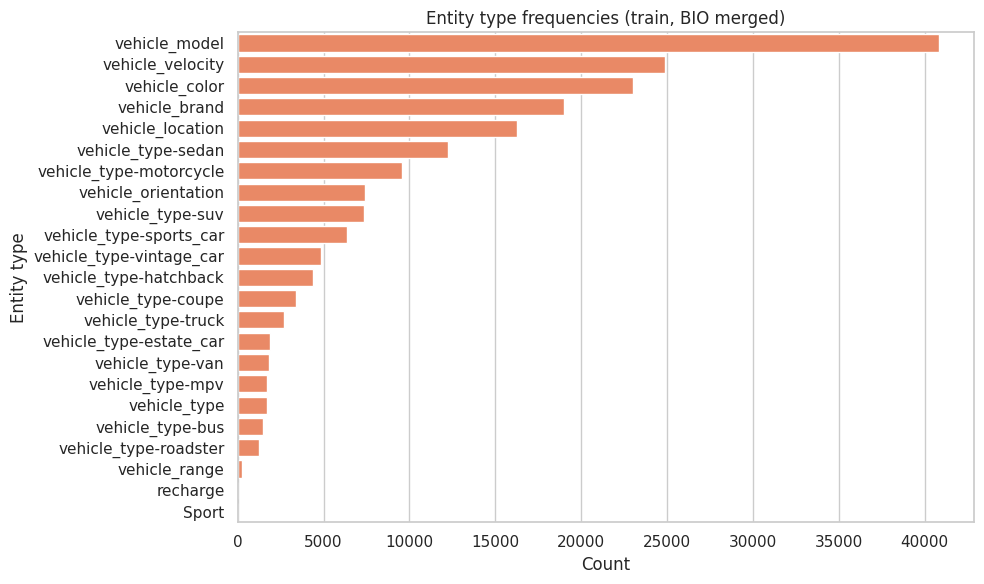

In [16]:
plt.figure(figsize=(10,6))
sns.barplot(x=ent_counts.values[:30], y=ent_counts.index[:30], color="coral")
plt.title("Entity type frequencies (train, BIO merged)")
plt.xlabel("Count")
plt.ylabel("Entity type")
plt.tight_layout()
plt.show()


In [17]:
# Clean tags (no BIO prefix)
def fix_other_tags(tag):
    if tag == "O":
        return "O"
    if "-" not in tag:
        # e.g., 'recharge', 'Sport' → treat as non-entity
        return "O"
    return tag

df_train["tag_clean"] = df_train["tag"].apply(fix_other_tags)
df_test["tag_clean"]  = df_test["tag"].apply(fix_other_tags)


In [18]:
# Rebuild clean sentence-level label sequences:

train_labels_clean = (
    df_train
    .sort_values(["sentence_id", "token_id"])
    .groupby("sentence_id")["tag_clean"]
    .apply(list)
    .tolist()
)

test_labels_clean = (
    df_test
    .sort_values(["sentence_id", "token_id"])
    .groupby("sentence_id")["tag_clean"]
    .apply(list)
    .tolist()
)

assert len(train_sentences) == len(train_labels_clean)
assert len(test_sentences)  == len(test_labels_clean)


In [20]:
Counter(df_train["tag_clean"]).most_common(10)


[('O', 357575),
 ('B-vehicle_color', 19461),
 ('B-vehicle_brand', 18073),
 ('B-vehicle_model', 18067),
 ('I-vehicle_model', 11659),
 ('B-vehicle_location', 11431),
 ('E-vehicle_model', 11105),
 ('I-vehicle_velocity', 11054),
 ('B-vehicle_velocity', 8306),
 ('B-vehicle_orientation', 5885)]

In [21]:
# Build Hugging Face Dataset + label maps

def build_hf_dataset(sentences, labels):
    return Dataset.from_dict({"tokens": sentences, "ner_tags": labels})

ds_train = build_hf_dataset(train_sentences, train_labels_clean)
ds_test  = build_hf_dataset(test_sentences,  test_labels_clean)

raw_datasets = DatasetDict({"train": ds_train, "test": ds_test})
raw_datasets


DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 21565
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 20777
    })
})

In [22]:
# Create tag2id / id2tag from clean tags:

unique_tags = sorted({t for seq in train_labels_clean for t in seq})
tag2id = {t: i for i, t in enumerate(unique_tags)}
id2tag = {i: t for t, i in tag2id.items()}

unique_tags, tag2id


(['B-vehicle_brand',
  'B-vehicle_color',
  'B-vehicle_location',
  'B-vehicle_model',
  'B-vehicle_orientation',
  'B-vehicle_range',
  'B-vehicle_type',
  'B-vehicle_type-bus',
  'B-vehicle_type-coupe',
  'B-vehicle_type-estate_car',
  'B-vehicle_type-hatchback',
  'B-vehicle_type-motorcycle',
  'B-vehicle_type-mpv',
  'B-vehicle_type-roadster',
  'B-vehicle_type-sedan',
  'B-vehicle_type-sports_car',
  'B-vehicle_type-suv',
  'B-vehicle_type-truck',
  'B-vehicle_type-van',
  'B-vehicle_type-vintage_car',
  'B-vehicle_velocity',
  'E-vehicle_brand',
  'E-vehicle_color',
  'E-vehicle_location',
  'E-vehicle_model',
  'E-vehicle_orientation',
  'E-vehicle_range',
  'E-vehicle_type',
  'E-vehicle_type-bus',
  'E-vehicle_type-coupe',
  'E-vehicle_type-estate_car',
  'E-vehicle_type-hatchback',
  'E-vehicle_type-motorcycle',
  'E-vehicle_type-mpv',
  'E-vehicle_type-roadster',
  'E-vehicle_type-sedan',
  'E-vehicle_type-sports_car',
  'E-vehicle_type-suv',
  'E-vehicle_type-truck',
  'E-v

In [23]:
# Sanity: no stray tags:

bad = {t for seq in train_labels_clean for t in seq if t not in tag2id}
bad


set()

In [25]:
# Tokenization and label alignment (for RoBERTa)

model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

def tokenize_and_align_labels(examples):
    tokenized = tokenizer(
        examples["tokens"],
        is_split_into_words=True,
        truncation=True,
        padding=False
    )
    aligned_labels = []
    for i, labels in enumerate(examples["ner_tags"]):
        word_ids = tokenized.word_ids(batch_index=i)
        prev_wid = None
        label_ids = []
        for wid in word_ids:
            if wid is None:
                label_ids.append(-100)
            elif wid != prev_wid:
                label_ids.append(tag2id[labels[wid]])
            else:
                label_ids.append(tag2id[labels[wid]])
            prev_wid = wid
        aligned_labels.append(label_ids)
    tokenized["labels"] = aligned_labels
    return tokenized

tokenized_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=["tokens", "ner_tags"]
)

tokenized_datasets

Map:   0%|          | 0/21565 [00:00<?, ? examples/s]

Map:   0%|          | 0/20777 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 21565
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 20777
    })
})

In [26]:
# Define model, data collator, metrics, trainer

from transformers import (
    AutoModelForTokenClassification,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer,
)
from seqeval.metrics import f1_score, classification_report

num_labels = len(unique_tags)

model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2tag,
    label2id=tag2id
).to(device)

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

def compute_metrics(pred):
    logits, labels = pred
    preds = logits.argmax(-1)

    true_labels, true_preds = [], []
    for p_seq, l_seq in zip(preds, labels):
        tl, tp = [], []
        for p, l in zip(p_seq, l_seq):
            if l == -100:
                continue
            tl.append(id2tag[int(l)])
            tp.append(id2tag[int(p)])
        true_labels.append(tl)
        true_preds.append(tp)

    return {"f1": f1_score(true_labels, true_preds)}


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
training_args = TrainingArguments(
    output_dir="./findvehicle-roberta-ner",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_steps=100,
    report_to=[]  # no wandb
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


/tmp/ipython-input-3429312814.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [29]:
# train and evaluate

trainer.train()


Epoch,Training Loss,Validation Loss,F1
1,0.177500,0.156266,0.883753
2,0.124200,0.103169,0.924942
3,0.101400,0.079095,0.943260
4,0.064100,0.064596,0.953596
5,0.062700,0.060190,0.956676


TrainOutput(global_step=6740, training_loss=0.15212215729920023, metrics={'train_runtime': 423.7159, 'train_samples_per_second': 254.475, 'train_steps_per_second': 15.907, 'total_flos': 2986296371602332.0, 'train_loss': 0.15212215729920023, 'epoch': 5.0})

In [30]:
eval_results = trainer.evaluate()
eval_results


{'eval_loss': 0.060189612209796906,
 'eval_f1': 0.9566755995327424,
 'eval_runtime': 22.8464,
 'eval_samples_per_second': 909.42,
 'eval_steps_per_second': 56.858,
 'epoch': 5.0}

In [31]:
# Detailed report

pred = trainer.predict(tokenized_datasets["test"])
logits, labels = pred.predictions, pred.label_ids
pred_ids = logits.argmax(-1)

all_true, all_pred = [], []
for p_seq, l_seq in zip(pred_ids, labels):
    tl, tp = [], []
    for p, l in zip(p_seq, l_seq):
        if l == -100:
            continue
        tl.append(id2tag[int(l)])
        tp.append(id2tag[int(p)])
    all_true.append(tl)
    all_pred.append(tp)

print(classification_report(all_true, all_pred, digits=3))


                          precision    recall  f1-score   support

           vehicle_brand      1.000     1.000     1.000     26081
           vehicle_color      1.000     1.000     1.000     31329
        vehicle_location      1.000     1.000     1.000     23531
           vehicle_model      1.000     1.000     1.000     34522
     vehicle_orientation      1.000     1.000     1.000      8265
           vehicle_range      1.000     1.000     1.000       205
            vehicle_type      1.000     1.000     1.000      2976
        vehicle_type-bus      0.870     0.802     0.834      1185
      vehicle_type-coupe      0.742     0.787     0.764      1913
 vehicle_type-estate_car      0.759     0.641     0.695      1052
  vehicle_type-hatchback      0.602     0.553     0.577      3637
 vehicle_type-motorcycle      0.956     0.989     0.972      4461
        vehicle_type-mpv      0.595     0.539     0.565      1347
   vehicle_type-roadster      0.593     0.382     0.465       675
      veh

In [32]:
# Inference helper + span grouping
# Simple tokenizer consistent with my data:

def simple_tokenize(text):
    text = re.sub(r'([,\.])', r' \1 ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.split()


In [33]:
# Predict tags for a token list:

def predict_tags_for_tokens(tokens):
    model.eval()
    with torch.no_grad():
        enc = tokenizer(tokens, is_split_into_words=True,
                        return_tensors="pt", truncation=True)
        enc = {k: v.to(device) for k, v in enc.items()}
        outputs = model(**enc)
        logits = outputs.logits[0]
        pred_ids = logits.argmax(-1).cpu().tolist()

    tmp = tokenizer(tokens, is_split_into_words=True)
    word_ids = tmp.word_ids()

    word_to_tag = {}
    for sub_idx, wid in enumerate(word_ids):
        if wid is None:
            continue
        if wid not in word_to_tag:
            word_to_tag[wid] = pred_ids[sub_idx]

    return [id2tag[word_to_tag[i]] for i in range(len(tokens))]


In [35]:
# Span reconstruction

def get_spans(tokens, tags):
    spans = []
    cur_type = None
    cur_tokens = []
    cur_start = None

    for i, (tok, tag) in enumerate(zip(tokens, tags)):
        if tag == "O":
            if cur_type is not None:
                spans.append({"type": cur_type,
                              "tokens": cur_tokens,
                              "start": cur_start,
                              "end": i-1})
                cur_type, cur_tokens, cur_start = None, [], None
            continue

        prefix, ent = tag.split("-", 1)
        if prefix == "B":
            if cur_type is not None:
                spans.append({"type": cur_type,
                              "tokens": cur_tokens,
                              "start": cur_start,
                              "end": i-1})
            cur_type = ent
            cur_tokens = [tok]
            cur_start = i
        else:
            if cur_type == ent:
                cur_tokens.append(tok)
            else:
                cur_type = ent
                cur_tokens = [tok]
                cur_start = i

    if cur_type is not None:
        spans.append({"type": cur_type,
                      "tokens": cur_tokens,
                      "start": cur_start,
                      "end": len(tokens)-1})
    return spans


In [36]:
# Test with example sentence:

sentence = "Find the Blue, green, reddish orange car."
tokens = simple_tokenize(sentence)
pred_tags = predict_tags_for_tokens(tokens)
spans = get_spans(tokens, pred_tags)

print("Tokens:", tokens)
print("Tags:  ", pred_tags)
print("\nExtracted spans:")
for s in spans:
    print(s)


Tokens: ['Find', 'the', 'Blue', ',', 'green', ',', 'reddish', 'orange', 'car', '.']
Tags:   ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Extracted spans:


# error analysis:

In [37]:
# Check predictions on actual test sentences

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Get a few test sentences and predictions in *word* space
def predict_tags_for_tokens(tokens):
    with torch.no_grad():
        enc = tokenizer(tokens, is_split_into_words=True,
                        return_tensors="pt", truncation=True)
        enc = {k: v.to(device) for k, v in enc.items()}
        outputs = model(**enc)
        logits = outputs.logits[0]
        pred_ids = logits.argmax(-1).cpu().tolist()

    tmp = tokenizer(tokens, is_split_into_words=True)
    word_ids = tmp.word_ids()

    word_to_tag = {}
    for sub_idx, wid in enumerate(word_ids):
        if wid is None:
            continue
        if wid not in word_to_tag:
            word_to_tag[wid] = pred_ids[sub_idx]

    return [id2tag[word_to_tag[i]] for i in range(len(tokens))]

# Inspect first 5 test sentences
for idx in range(5):
    tokens = test_sentences[idx]
    gold   = test_labels_clean[idx]
    pred   = predict_tags_for_tokens(tokens)
    print(f"\nSentence {idx}")
    print("TOK:", " ".join(tokens[:50]))
    print("GOLD:", gold[:50])
    print("PRED:", pred[:50])



Sentence 0
TOK: All of a sudden , a brand-new Silver van appears in the Top-Left of the screen at a speed of 85 kilometers an hour
GOLD: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-vehicle_color', 'B-vehicle_type', 'O', 'O', 'O', 'B-vehicle_location', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-vehicle_velocity', 'I-vehicle_velocity', 'I-vehicle_velocity', 'E-vehicle_velocity']
PRED: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-vehicle_color', 'B-vehicle_type', 'O', 'O', 'O', 'B-vehicle_location', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-vehicle_velocity', 'I-vehicle_velocity', 'I-vehicle_velocity', 'E-vehicle_velocity']

Sentence 1
TOK: Find the VAN located in the TOP-LEFT and bottom left whose colors are Silver and dark-brown . As far as I am concerned , they are 297
GOLD: ['O', 'O', 'B-vehicle_type', 'O', 'O', 'O', 'B-vehicle_location', 'O', 'B-vehicle_location', 'E-vehicle_location', 'O', 'O', 'O', 'B-vehicle_color', 'O', 'B-vehicle_color', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-vehicle

In [38]:
# Token‑level confusion counts (what does the model confuse?)

from collections import defaultdict

# Build confusion counts on the whole test set
confusion = defaultdict(lambda: defaultdict(int))

for tokens, gold_seq in zip(test_sentences[:2000], test_labels_clean[:2000]):  # limit for speed
    pred_seq = predict_tags_for_tokens(tokens)
    for g, p in zip(gold_seq, pred_seq):
        confusion[g][p] += 1

# Show a few rows
for gold_tag, row in list(confusion.items())[:15]:
    total = sum(row.values())
    top_preds = sorted(row.items(), key=lambda x: x[1], reverse=True)[:5]
    print(f"\nGold tag: {gold_tag} (count={total})")
    for pred_tag, c in top_preds:
        print(f"  predicted {pred_tag}: {c}")



Gold tag: O (count=31800)
  predicted O: 31797
  predicted E-vehicle_model: 2
  predicted E-vehicle_type-sedan: 1

Gold tag: B-vehicle_color (count=2277)
  predicted B-vehicle_color: 2277

Gold tag: B-vehicle_type (count=1451)
  predicted B-vehicle_type: 1451

Gold tag: B-vehicle_location (count=1591)
  predicted B-vehicle_location: 1591

Gold tag: B-vehicle_velocity (count=855)
  predicted B-vehicle_velocity: 855

Gold tag: I-vehicle_velocity (count=1098)
  predicted I-vehicle_velocity: 1098

Gold tag: E-vehicle_velocity (count=549)
  predicted E-vehicle_velocity: 549

Gold tag: E-vehicle_location (count=691)
  predicted E-vehicle_location: 691

Gold tag: B-vehicle_range (count=181)
  predicted B-vehicle_range: 181

Gold tag: B-vehicle_orientation (count=901)
  predicted B-vehicle_orientation: 901

Gold tag: E-vehicle_orientation (count=222)
  predicted E-vehicle_orientation: 222

Gold tag: E-vehicle_color (count=469)
  predicted E-vehicle_color: 469

Gold tag: E-vehicle_type (count=

In [39]:
# Inspect model logits for your custom sentence

import numpy as np

def analyze_sentence(sentence):
    tokens = re.sub(r'([,\.])', r' \1 ', sentence)
    tokens = re.sub(r'\s+', ' ', tokens).strip().split()

    with torch.no_grad():
        enc = tokenizer(tokens, is_split_into_words=True,
                        return_tensors="pt", truncation=True)
        enc = {k: v.to(device) for k, v in enc.items()}
        outputs = model(**enc)
        logits = outputs.logits[0].cpu().numpy()   # [seq_len, num_labels]

    # Map to words
    tmp = tokenizer(tokens, is_split_into_words=True)
    word_ids = tmp.word_ids()

    print("Sentence tokens:", tokens)
    for wid in range(len(tokens)):
        # indices of subwords belonging to this word
        sub_idx = [i for i, w in enumerate(word_ids) if w == wid]
        if not sub_idx:
            continue
        # average logits across subwords
        avg_logit = np.mean(logits[sub_idx], axis=0)
        top_ids = avg_logit.argsort()[-5:][::-1]
        top_labels = [(id2tag[i], float(avg_logit[i])) for i in top_ids]
        print(f"\nWord '{tokens[wid]}'")
        for lab, score in top_labels:
            print(f"  {lab:20s} {score:8.3f}")

analyze_sentence("Find the Blue, green, reddish orange car.")


Sentence tokens: ['Find', 'the', 'Blue', ',', 'green', ',', 'reddish', 'orange', 'car', '.']

Word 'Find'
  O                      13.344
  B-vehicle_type-sports_car    0.499
  B-vehicle_range         0.394
  B-vehicle_color         0.371
  I-vehicle_type-mpv      0.347

Word 'the'
  O                      13.384
  B-vehicle_type-sports_car    0.464
  B-vehicle_color         0.436
  B-vehicle_type-hatchback    0.350
  B-vehicle_range         0.333

Word 'Blue'
  O                      12.154
  B-vehicle_color         3.786
  B-vehicle_range         1.232
  E-vehicle_color         0.855
  B-vehicle_type-hatchback    0.628

Word ','
  O                      12.992
  B-vehicle_color         1.369
  B-vehicle_range         0.571
  B-vehicle_location      0.562
  E-vehicle_color         0.509

Word 'green'
  O                      11.908
  B-vehicle_color         3.917
  B-vehicle_range         1.418
  E-vehicle_color         1.185
  B-vehicle_type-hatchback    0.732

Word ','
  O          

In [40]:
# Compare dataset‑style sentence vs your short command
# Dataset-like sentence (from your file)
template_sentence = "Please help me find the blue car on the bottom-left of the image ."
template_tokens = template_sentence.split()
template_pred = predict_tags_for_tokens(template_tokens)
print("\nDataset-like sentence:")
print("TOK:", template_tokens)
print("TAG:", template_pred)

# Your sentence
cmd_sentence = "Find the Blue, green, reddish orange car."
cmd_tokens = re.sub(r'([,\.])', r' \1 ', cmd_sentence)
cmd_tokens = re.sub(r'\s+', ' ', cmd_tokens).strip().split()
cmd_pred = predict_tags_for_tokens(cmd_tokens)
print("\nCommand-like sentence:")
print("TOK:", cmd_tokens)
print("TAG:", cmd_pred)



Dataset-like sentence:
TOK: ['Please', 'help', 'me', 'find', 'the', 'blue', 'car', 'on', 'the', 'bottom-left', 'of', 'the', 'image', '.']
TAG: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Command-like sentence:
TOK: ['Find', 'the', 'Blue', ',', 'green', ',', 'reddish', 'orange', 'car', '.']
TAG: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [41]:
# Span‑level error analysis on test set
def get_spans(tokens, tags):
    spans = []
    cur_type = None
    cur_tokens = []
    cur_start = None
    for i, (tok, tag) in enumerate(zip(tokens, tags)):
        if tag == "O":
            if cur_type is not None:
                spans.append((cur_type, " ".join(cur_tokens), cur_start, i-1))
                cur_type, cur_tokens, cur_start = None, [], None
            continue
        prefix, ent = tag.split("-", 1)
        if prefix == "B":
            if cur_type is not None:
                spans.append((cur_type, " ".join(cur_tokens), cur_start, i-1))
            cur_type = ent
            cur_tokens = [tok]
            cur_start = i
        else:
            if cur_type == ent:
                cur_tokens.append(tok)
            else:
                cur_type = ent
                cur_tokens = [tok]
                cur_start = i
    if cur_type is not None:
        spans.append((cur_type, " ".join(cur_tokens), cur_start, len(tokens)-1))
    return spans

# Collect span-level TP/FP/FN on first N test sentences
from collections import Counter

span_tp = Counter()
span_fp = Counter()
span_fn = Counter()

N = 500  # adjust as needed

for tokens, gold_seq in zip(test_sentences[:N], test_labels_clean[:N]):
    pred_seq = predict_tags_for_tokens(tokens)
    gold_spans = set(get_spans(tokens, gold_seq))
    pred_spans = set(get_spans(tokens, pred_seq))

    for sp in pred_spans:
        if sp in gold_spans:
            span_tp[sp[0]] += 1
        else:
            span_fp[sp[0]] += 1
    for sp in gold_spans:
        if sp not in pred_spans:
            span_fn[sp[0]] += 1

print("\nSpan-level stats per entity type:")
for ent_type in sorted(set(list(span_tp)+list(span_fp)+list(span_fn))):
    tp = span_tp[ent_type]
    fp = span_fp[ent_type]
    fn = span_fn[ent_type]
    prec = tp / (tp + fp) if tp + fp > 0 else 0.0
    rec  = tp / (tp + fn) if tp + fn > 0 else 0.0
    f1   = 2*prec*rec/(prec+rec) if prec+rec > 0 else 0.0
    print(f"{ent_type:25s} TP={tp:5d} FP={fp:5d} FN={fn:5d}  P={prec:.3f} R={rec:.3f} F1={f1:.3f}")



Span-level stats per entity type:
vehicle_color             TP=  754 FP=    0 FN=    0  P=1.000 R=1.000 F1=1.000
vehicle_location          TP=  577 FP=    0 FN=    0  P=1.000 R=1.000 F1=1.000
vehicle_orientation       TP=  339 FP=    0 FN=    0  P=1.000 R=1.000 F1=1.000
vehicle_range             TP=   81 FP=    0 FN=    0  P=1.000 R=1.000 F1=1.000
vehicle_type              TP=  754 FP=    0 FN=    0  P=1.000 R=1.000 F1=1.000
vehicle_velocity          TP=  266 FP=    0 FN=    0  P=1.000 R=1.000 F1=1.000


# rectification:

In [42]:
import numpy as np

def decode_with_margin(tokens, margin=6.0):
    model.eval()
    with torch.no_grad():
        enc = tokenizer(tokens, is_split_into_words=True,
                        return_tensors="pt", truncation=True)
        enc = {k: v.to(device) for k, v in enc.items()}
        outputs = model(**enc)
        logits = outputs.logits[0].cpu().numpy()  # [seq_len_subword, num_labels]

    # Map back to words
    tmp = tokenizer(tokens, is_split_into_words=True)
    word_ids = tmp.word_ids()

    word_logits = []
    for wid in range(len(tokens)):
        sub_idx = [i for i, w in enumerate(word_ids) if w == wid]
        if not sub_idx:
            # no subwords (shouldn't happen with this tokenizer), use zeros
            word_logits.append(np.zeros(logits.shape[-1]))
        else:
            word_logits.append(np.mean(logits[sub_idx], axis=0))

    pred_tags = []
    for wl in word_logits:
        # index for O
        o_id = tag2id["O"]
        score_o = wl[o_id]

        # best non-O label
        ent_scores = wl.copy()
        ent_scores[o_id] = -1e9  # exclude O
        best_ent_id = int(ent_scores.argmax())
        score_ent = ent_scores[best_ent_id]

        if score_ent >= score_o - margin:
            pred_tags.append(id2tag[best_ent_id])
        else:
            pred_tags.append("O")

    return pred_tags


In [44]:
sentence = "Find the Blue, green, reddish orange car."
tokens = re.sub(r'([,\.])', r' \1 ', sentence)
tokens = re.sub(r'\s+', ' ', tokens).strip().split()

tags_margin = decode_with_margin(tokens, margin=12.0)
print("Tokens:", tokens)
print("Tags:  ", tags_margin)
spans = get_spans(tokens, tags_margin)
print("\nSpans:")
for s in spans:
    print(s)


Tokens: ['Find', 'the', 'Blue', ',', 'green', ',', 'reddish', 'orange', 'car', '.']
Tags:   ['O', 'O', 'B-vehicle_color', 'B-vehicle_color', 'B-vehicle_color', 'B-vehicle_color', 'B-vehicle_color', 'E-vehicle_color', 'B-vehicle_type', 'E-vehicle_orientation']

Spans:
('vehicle_color', 'Blue', 2, 2)
('vehicle_color', ',', 3, 3)
('vehicle_color', 'green', 4, 4)
('vehicle_color', ',', 5, 5)
('vehicle_color', 'reddish orange', 6, 7)
('vehicle_orientation', '.', 9, 9)


In [45]:
sentence = "Please help me find the blue car on the bottom-left of the image ."
tokens = re.sub(r'([,\.])', r' \1 ', sentence)
tokens = re.sub(r'\s+', ' ', tokens).strip().split()

tags_margin = decode_with_margin(tokens, margin=12.0)
print("Tokens:", tokens)
print("Tags:  ", tags_margin)
spans = get_spans(tokens, tags_margin)
print("\nSpans:")
for s in spans:
    print(s)


Tokens: ['Please', 'help', 'me', 'find', 'the', 'blue', 'car', 'on', 'the', 'bottom-left', 'of', 'the', 'image', '.']
Tags:   ['O', 'O', 'O', 'O', 'O', 'B-vehicle_color', 'B-vehicle_type', 'O', 'O', 'B-vehicle_location', 'O', 'O', 'O', 'O']

Spans:
('vehicle_color', 'blue', 5, 5)
('vehicle_type', 'car', 6, 6)
('vehicle_location', 'bottom-left', 9, 9)


In [46]:
sentence = "I saw the white toyota near the signal."
tokens = re.sub(r'([,\.])', r' \1 ', sentence)
tokens = re.sub(r'\s+', ' ', tokens).strip().split()

tags_margin = decode_with_margin(tokens, margin=12.0)
print("Tokens:", tokens)
print("Tags:  ", tags_margin)
spans = get_spans(tokens, tags_margin)
print("\nSpans:")
for s in spans:
    print(s)


Tokens: ['I', 'saw', 'the', 'white', 'toyota', 'near', 'the', 'signal', '.']
Tags:   ['O', 'O', 'O', 'B-vehicle_color', 'B-vehicle_type', 'O', 'O', 'B-vehicle_range', 'E-vehicle_orientation']

Spans:
('vehicle_color', 'white', 3, 3)
('vehicle_type', 'toyota', 4, 4)
('vehicle_orientation', '.', 8, 8)


In [53]:
def entity_type(tag):
    if tag == "O":
        return "O"
    return tag.split("-", 1)[1]

pred_tokens_by_ent = defaultdict(Counter)

for tokens in test_sentences[:N]:
    pred_tags = predict_tags_for_tokens(tokens)
    for tok, tag in zip(tokens, pred_tags):
        et = entity_type(tag)
        if et != "O":
            pred_tokens_by_ent[et][tok] += 1

for et, counter in sorted(pred_tokens_by_ent.items(), key=lambda x: x[0]):
    print(f"\nENTITY TYPE (pred): {et}")
    for tok, c in counter.most_common(10):
        print(f"  {tok:20s} {c}")



ENTITY TYPE (pred): vehicle_brand
  BMW                  2195
  Honda                1996
  Ferrari              1138
  Ford                 839
  Alfa                 618
  Romeo                618
  Suzuki               591
  BAIC                 535
  Audi                 519
  Dongfeng             468

ENTITY TYPE (pred): vehicle_color
  Black                1845
  black                1087
  BLACK                950
  Silver               926
  blue                 800
  silver               714
  red                  643
  green                562
  grey                 552
  yellow               525

ENTITY TYPE (pred): vehicle_location
  bottom               1089
  top                  1089
  left                 1041
  right                1038
  part                 974
  Bottom               858
  Top                  838
  BOTTOM               409
  TOP                  407
  bottom-left          397

ENTITY TYPE (pred): vehicle_model
  zero                 3641
  five    

In [54]:
sentence = "Please help me find the Black BMW sedan on the bottom-left of the image."
tokens = re.sub(r'([,\.])', r' \1 ', sentence)
tokens = re.sub(r'\s+', ' ', tokens).strip().split()

tags_margin = decode_with_margin(tokens, margin=12.0)
print("Tokens:", tokens)
print("Tags:  ", tags_margin)
spans = get_spans(tokens, tags_margin)
print("\nSpans:")
for s in spans:
    print(s)

Tokens: ['Please', 'help', 'me', 'find', 'the', 'Black', 'BMW', 'sedan', 'on', 'the', 'bottom-left', 'of', 'the', 'image', '.']
Tags:   ['O', 'O', 'O', 'O', 'O', 'B-vehicle_color', 'B-vehicle_type-sedan', 'E-vehicle_type-hatchback', 'O', 'O', 'B-vehicle_location', 'O', 'O', 'O', 'O']

Spans:
('vehicle_color', 'Black', 5, 5)
('vehicle_type-hatchback', 'sedan', 7, 7)
('vehicle_location', 'bottom-left', 10, 10)


In [55]:
sentence = "Find the silver Honda SUV on the Top right of the image."
tokens = re.sub(r'([,\.])', r' \1 ', sentence)
tokens = re.sub(r'\s+', ' ', tokens).strip().split()

tags_margin = decode_with_margin(tokens, margin=12.0)
print("Tokens:", tokens)
print("Tags:  ", tags_margin)
spans = get_spans(tokens, tags_margin)
print("\nSpans:")
for s in spans:
    print(s)

Tokens: ['Find', 'the', 'silver', 'Honda', 'SUV', 'on', 'the', 'Top', 'right', 'of', 'the', 'image', '.']
Tags:   ['O', 'O', 'B-vehicle_color', 'B-vehicle_brand', 'B-vehicle_model', 'O', 'O', 'B-vehicle_location', 'E-vehicle_location', 'O', 'O', 'O', 'O']

Spans:
('vehicle_color', 'silver', 2, 2)
('vehicle_brand', 'Honda', 3, 3)
('vehicle_model', 'SUV', 4, 4)
('vehicle_location', 'Top right', 7, 8)


In [56]:
sentence = "Let the wise man assist me to find out the Grey Audi hatchback in the lower-part of the image."
tokens = re.sub(r'([,\.])', r' \1 ', sentence)
tokens = re.sub(r'\s+', ' ', tokens).strip().split()

tags_margin = decode_with_margin(tokens, margin=12.0)
print("Tokens:", tokens)
print("Tags:  ", tags_margin)
spans = get_spans(tokens, tags_margin)
print("\nSpans:")
for s in spans:
    print(s)

Tokens: ['Let', 'the', 'wise', 'man', 'assist', 'me', 'to', 'find', 'out', 'the', 'Grey', 'Audi', 'hatchback', 'in', 'the', 'lower-part', 'of', 'the', 'image', '.']
Tags:   ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-vehicle_color', 'B-vehicle_brand', 'B-vehicle_model', 'O', 'O', 'B-vehicle_location', 'O', 'O', 'O', 'E-vehicle_orientation']

Spans:
('vehicle_color', 'Grey', 10, 10)
('vehicle_brand', 'Audi', 11, 11)
('vehicle_model', 'hatchback', 12, 12)
('vehicle_location', 'lower-part', 15, 15)
('vehicle_orientation', '.', 19, 19)


In [60]:
sentence = "There is a red Ferrari sports car driving left with 124 kilometers per hour ."
tokens = re.sub(r'([,\.])', r' \1 ', sentence)
tokens = re.sub(r'\s+', ' ', tokens).strip().split()

tags_margin = decode_with_margin(tokens, margin=12.0)
print("Tokens:", tokens)
print("Tags:  ", tags_margin)
spans = get_spans(tokens, tags_margin)
print("\nSpans:")
for s in spans:
    print(s)

Tokens: ['There', 'is', 'a', 'red', 'Ferrari', 'sports', 'car', 'driving', 'left', 'with', '124', 'kilometers', 'per', 'hour', '.']
Tags:   ['O', 'O', 'O', 'B-vehicle_color', 'B-vehicle_type-sports_car', 'B-vehicle_model', 'E-vehicle_type-sports_car', 'O', 'B-vehicle_orientation', 'O', 'B-vehicle_velocity', 'I-vehicle_velocity', 'I-vehicle_velocity', 'E-vehicle_velocity', 'E-vehicle_orientation']

Spans:
('vehicle_color', 'red', 3, 3)
('vehicle_type-sports_car', 'Ferrari', 4, 4)
('vehicle_type-sports_car', 'car', 6, 6)
('vehicle_orientation', 'left', 8, 8)
('vehicle_orientation', '.', 14, 14)


# Final Evaluations:

In [70]:
# Load the trained checkpoint

from transformers import AutoModelForTokenClassification

model_path = "./findvehicle-roberta-ner/checkpoint-6740"  # change if different

model = AutoModelForTokenClassification.from_pretrained(
    model_path,
    num_labels=len(unique_tags),
    id2label=id2tag,
    label2id=tag2id
).to(device)


In [71]:
# Define metrics and evaluation-only Trainer


from seqeval.metrics import (
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
)
from transformers import (
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer,
)

def compute_metrics(pred):
    logits, labels = pred
    preds = logits.argmax(-1)

    true_labels, true_preds = [], []
    for p_seq, l_seq in zip(preds, labels):
        tl, tp = [], []
        for p, l in zip(p_seq, l_seq):
            if l == -100:
                continue
            tl.append(id2tag[int(l)])
            tp.append(id2tag[int(p)])
        true_labels.append(tl)
        true_preds.append(tp)

    return {
        "f1": f1_score(true_labels, true_preds),
        "precision": precision_score(true_labels, true_preds),
        "recall": recall_score(true_labels, true_preds),
        "accuracy": accuracy_score(true_labels, true_preds),
    }

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

eval_args = TrainingArguments(
    output_dir="./eval-only",
    per_device_eval_batch_size=32,
    report_to=[],
)


In [72]:
eval_trainer = Trainer(
    model=model,
    args=eval_args,
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


/tmp/ipython-input-36099840.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


In [73]:
# Run evaluation (multiple times )
metrics = eval_trainer.evaluate()
metrics


{'eval_loss': 0.05978252738714218,
 'eval_model_preparation_time': 0.003,
 'eval_f1': 0.9566755995327424,
 'eval_precision': 0.9530301647423903,
 'eval_recall': 0.9603490297066127,
 'eval_accuracy': 0.9813082529949888,
 'eval_runtime': 23.3497,
 'eval_samples_per_second': 889.818,
 'eval_steps_per_second': 27.838}

In [74]:
import pandas as pd

all_runs = []

for i in range(5):
    print(f"\n=== Eval run {i+1} ===")
    m = eval_trainer.evaluate()
    # m contains: eval_loss, eval_f1, eval_precision, eval_recall, eval_accuracy, epoch
    print(m)
    m_row = {
        "run": i + 1,
        "loss": m.get("eval_loss"),
        "f1": m.get("eval_f1"),
        "precision": m.get("eval_precision"),
        "recall": m.get("eval_recall"),
        "accuracy": m.get("eval_accuracy"),
    }
    all_runs.append(m_row)

df_metrics = pd.DataFrame(all_runs)
print("\nPer-run metrics:")
print(df_metrics)

print("\nSummary over runs:")
print(df_metrics[["f1", "precision", "recall", "accuracy"]].describe())



=== Eval run 1 ===


{'eval_loss': 0.05978252738714218, 'eval_model_preparation_time': 0.003, 'eval_f1': 0.9566755995327424, 'eval_precision': 0.9530301647423903, 'eval_recall': 0.9603490297066127, 'eval_accuracy': 0.9813082529949888, 'eval_runtime': 23.7213, 'eval_samples_per_second': 875.88, 'eval_steps_per_second': 27.402}

=== Eval run 2 ===
{'eval_loss': 0.05978252738714218, 'eval_model_preparation_time': 0.003, 'eval_f1': 0.9566755995327424, 'eval_precision': 0.9530301647423903, 'eval_recall': 0.9603490297066127, 'eval_accuracy': 0.9813082529949888, 'eval_runtime': 23.7407, 'eval_samples_per_second': 875.164, 'eval_steps_per_second': 27.379}

=== Eval run 3 ===
{'eval_loss': 0.05978252738714218, 'eval_model_preparation_time': 0.003, 'eval_f1': 0.9566755995327424, 'eval_precision': 0.9530301647423903, 'eval_recall': 0.9603490297066127, 'eval_accuracy': 0.9813082529949888, 'eval_runtime': 23.6733, 'eval_samples_per_second': 877.656, 'eval_steps_per_second': 27.457}

=== Eval run 4 ===
{'eval_loss': 0.0

In [77]:
# Save model + tokenizer to a single directory

best_ckpt = "./findvehicle-roberta-ner/checkpoint-6740"

from transformers import AutoModelForTokenClassification, AutoTokenizer

model = AutoModelForTokenClassification.from_pretrained(best_ckpt)
tokenizer = AutoTokenizer.from_pretrained(best_ckpt)

export_dir = "./findvehicle_roberta_export"
model.save_pretrained(export_dir)
tokenizer.save_pretrained(export_dir)

# Optionally also save id2tag / tag2id mappings you built yourself
import json
with open(f"{export_dir}/id2tag.json", "w") as f:
    json.dump(id2tag, f)
with open(f"{export_dir}/tag2id.json", "w") as f:
    json.dump(tag2id, f)


In [78]:
import shutil
from google.colab import files

zip_name = "findvehicle_roberta_export.zip"
shutil.make_archive("findvehicle_roberta_export", "zip", export_dir)

files.download(zip_name)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# how to load the model later:

!pip install -q transformers

import json
import torch
from transformers import AutoModelForTokenClassification, AutoTokenizer

export_dir = "findvehicle_roberta_export"  # unzip here first

tokenizer = AutoTokenizer.from_pretrained(export_dir)
model = AutoModelForTokenClassification.from_pretrained(export_dir)

with open(f"{export_dir}/id2tag.json") as f:
    id2tag = {int(k): v for k, v in json.load(f).items()}
with open(f"{export_dir}/tag2id.json") as f:
    tag2id = json.load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# Prediction helper (same as in your project):


import re

def simple_tokenize(text):
    text = re.sub(r'([,\.])', r' \1 ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.split()

def predict_tags_for_tokens(tokens):
    model.eval()
    with torch.no_grad():
        enc = tokenizer(tokens, is_split_into_words=True,
                        return_tensors="pt", truncation=True)
        enc = {k: v.to(device) for k, v in enc.items()}
        outputs = model(**enc)
        logits = outputs.logits[0]
        pred_ids = logits.argmax(-1).cpu().tolist()

    tmp = tokenizer(tokens, is_split_into_words=True)
    word_ids = tmp.word_ids()

    word_to_tag = {}
    for sub_idx, wid in enumerate(word_ids):
        if wid is None:
            continue
        if wid not in word_to_tag:
            word_to_tag[wid] = pred_ids[sub_idx]

    return [id2tag[word_to_tag[i]] for i in range(len(tokens))]


# Span grouping:


def get_spans(tokens, tags):
    spans = []
    cur_type = None
    cur_tokens = []
    cur_start = None
    for i, (tok, tag) in enumerate(zip(tokens, tags)):
        if tag == "O":
            if cur_type is not None:
                spans.append({"type": cur_type, "tokens": cur_tokens,
                              "start": cur_start, "end": i-1})
                cur_type, cur_tokens, cur_start = None, [], None
            continue
        prefix, ent = tag.split("-", 1)
        if prefix == "B":
            if cur_type is not None:
                spans.append({"type": cur_type, "tokens": cur_tokens,
                              "start": cur_start, "end": i-1})
            cur_type = ent
            cur_tokens = [tok]
            cur_start = i
        else:
            if cur_type == ent:
                cur_tokens.append(tok)
            else:
                cur_type = ent
                cur_tokens = [tok]
                cur_start = i
    if cur_type is not None:
        spans.append({"type": cur_type, "tokens": cur_tokens,
                      "start": cur_start, "end": len(tokens)-1})
    return spans


# Demo in class:

sentence = "Please help me find the Black BMW sedan on the bottom-left of the image."
tokens = simple_tokenize(sentence)
tags = predict_tags_for_tokens(tokens)
spans = get_spans(tokens, tags)
print(list(zip(tokens, tags)))
print(spans)
